In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib

import matplotlib.pyplot as plt

import os
import random
import math

from torch.utils.data.dataset import Dataset

INPUT_PATH = "./output/nodule_npy/"
OUTPUT_PATH = "./output/"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 20
nz = 100
n_epochs = 30
ngf = 64
ngpu = 1
print(device)

cuda:0


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def chunks(arr, m):
    nchunk = int(math.ceil(len(arr) / float(m)))
    return [arr[i:i + nchunk] for i in range(0, len(arr), nchunk)]

def five_folder(arr, number):
    training_set = []
    test_set = []
    for j in range(len(arr)):
        if number == j:
            test_set.extend(arr[j])
        else:
            training_set.extend(arr[j])
    return training_set, test_set


class MyDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __getitem__(self, index):#返回的是tensor
        img = self.images[index]
        return img

    def __len__(self):
        return len(self.images)

In [5]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.project = nn.Sequential(
          nn.Linear(nz, 1 * 5 * 5 * ngf * 4, bias=False)
        )
        self.deconv = nn.Sequential(
          # input is Z, going into a deconvolution
          # state size. BATCH_SIZE x (ngf*8) x 4 x 4 x 4
#           nn.ConvTranspose3d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
#           nn.BatchNorm3d(ngf * 4),
#           nn.ReLU(True),
          # state size. BATCH_SIZE x (ngf*4) x 1 x 5 x 5
          nn.ConvTranspose3d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(ngf * 2),
          nn.ReLU(True),
          # state size. BATCH_SIZE x (ngf*2) x 2 x 10 x 10
          nn.ConvTranspose3d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm3d(ngf),
          nn.ReLU(True),
          # state size. BATCH_SIZE x (ngf) x 4 x 20 x 20
          nn.ConvTranspose3d(ngf, 1, kernel_size=4, stride=2, padding=1, bias=False),
          nn.Tanh()
          # state size. BATCH_SIZE x 1 x 8 x 40 x 40
        )

    def forward(self, input):
        x = self.project(input)
        # Conv3d的规定输入数据格式为(batch, channel, Depth, Height, Width)
#         print(x.shape)
        x = x.view(-1, ngf * 4, 1, 5, 5)
#         x = self.deconv(x)
        
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.deconv, x, range(self.ngpu))
        else:
            output = self.deconv(x)

        return output


# Discriminator
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=(2,9,9)):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv3d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=kernel_size,
                                stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=(2,9,9), num_routes=32 * 12 * 12 * 6):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
          nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=(1,2,2), padding=0) 
                      for _ in range(num_capsules)])
  
    def forward(self, x):
        u = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
        u = torch.cat(u, dim=-1)
        return self.squash(u)
  
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor



class DigitCaps(nn.Module):
    def __init__(self, num_capsules=1, num_routes=32 * 12 * 12 * 6, in_channels=8, out_channels=16, num_iterations=3):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.num_iterations = num_iterations
        self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels)).to(device)

    def forward(self, x):
        # 矩阵相乘
        # x.size(): [1, batch_size, in_capsules, 1, dim_in_capsule]
        # weight.size(): [num_capsules, 1, num_route, in_channels, out_channels]
        priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]
        logits = Variable(torch.zeros(*priors.size())).to(device)

        for i in range(self.num_iterations):
            probs = softmax(logits, dim=2)
            outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

            if i != self.num_routes - 1:
                delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                logits = logits + delta_logits
        
        return outputs.squeeze()
  
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class CapsNet(nn.Module):
    def __init__(self, ngpu):
        super(CapsNet, self).__init__()
        self.ngpu = ngpu
        
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()

    def forward(self, data):
        if data.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.conv_layer, data, range(self.ngpu))
            output = nn.parallel.data_parallel(self.primary_capsules, output, range(self.ngpu))
            output = nn.parallel.data_parallel(self.digit_capsules, output, range(self.ngpu))
        else:
            output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))

        classes = (output ** 2).sum(dim=-1) ** 0.5        
        return classes, output


class CapsuleLoss(nn.Module):
    def __init__(self):
        super(CapsuleLoss, self).__init__()

    def forward(self, classes, labels):
        left = F.relu(0.9 - classes, inplace=True) ** 2
        right = F.relu(classes - 0.1, inplace=True) ** 2

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        return margin_loss / classes.size(0)

In [5]:
input_data = os.listdir(INPUT_PATH)
npy_list = []
benign_set = []

for level_num in range(5): #遍历patient文件夹——study指代每一个study文件夹
    if level_num == 2:
        continue
    npy_file_path = os.path.join(INPUT_PATH, "malignancy_" + str(level_num + 1))
    npy_files = os.listdir(npy_file_path)
    if level_num < 2:
        for i in npy_files:
            npy_path = os.path.join(npy_file_path, i)
            single_npy = np.load(npy_path)
            single_npy = (single_npy - 127.5) / 127.5
            benign_set.append(single_npy)
    else:
        for i in npy_files:
            npy_path = os.path.join(npy_file_path, i)
            single_npy = np.load(npy_path)
            single_fliplr_npy = np.fliplr(single_npy)
            single_npy = (single_npy - 127.5) / 127.5
            single_fliplr_npy = (single_fliplr_npy - 127.5) / 127.5
            npy_list.append(single_npy)
            npy_list.append(single_fliplr_npy)

print(len(npy_list))
random.shuffle(npy_list)
training_set = npy_list[:len(npy_list)-500]
test_set = npy_list[len(npy_list)-500:]

malignancy_set = test_set
np.save(OUTPUT_PATH + "malignancy.npy", np.array(malignancy_set))

np.save(OUTPUT_PATH + "benign.npy", np.array(benign_set))

# npy_chunks = chunks(npy_list, 5)
train_loader = torch.utils.data.DataLoader(MyDataset(training_set), batch_size=BATCH_SIZE, shuffle=True)

### Train
print("NOW the training STARTS:")

netD = CapsNet(ngpu).to(device)

netG = Generator(ngpu).to(device)
netG.apply(weights_init)

criterion = CapsuleLoss()

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

D_losses = []
G_losses = []

pred_G = []

for epoch in range(n_epochs):
    print("-----THE [{}/{}] epoch start-----".format(epoch + 1, n_epochs))
    for j, data in enumerate(train_loader, 0):
#                     print(j, data.shape) #torch.Size([32, 1, 8, 40, 40])

#                     plt.figure()
#                     for lenc in range(data.shape[0]):
#                         for len_img in range(8):
#                             plt.subplot(2, 4, len_img + 1)
#                             pixel_array = data[lenc][0][len_img]
#                             print(pixel_array)
#                             plt.imshow(pixel_array, cmap="gray")
#                         plt.show()


#                     pixel_array = data[0][0][0][20]
#                     print(pixel_array)

#                     data = data / 255.0
#                     pixel_array = data[0][0][0][20]
#                     print(pixel_array)
        ############################
        # (1) Update D network: minimize Lm(D(x), T = 1) + Lm(D(G(z)), T = 0)
        ###########################
        # train with real

        netD.train()

        netD.zero_grad()
        real_cpu = data.to(device, dtype=torch.float)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)   

        classes_d_real, output_d_real = netD(real_cpu)
        errD_real = criterion(classes_d_real, label)
        errD_real.backward()
        D_x = output_d_real.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        classes_d_fake, output_d_fake = netD(fake.detach())

        errD_fake = criterion(classes_d_fake, label)
        errD_fake.backward()
        D_G_z1 = output_d_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: minimize Lm(D(G(z)), T=1)
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        netD.eval()

        classes_g, output_g = netD(fake)
        pred_G.append(classes_g[0].item())
        errG = criterion(classes_g, label)
        errG.backward()
        D_G_z2 = output_g.mean().item()
        optimizerG.step()

        print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (j + 1, len(train_loader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        D_losses.append(errD.item())
        G_losses.append(errG.item())

    print("-----THE [{}/{}] epoch end-----".format(epoch + 1, n_epochs))


2936
NOW the training STARTS:
-----THE [1/30] epoch start-----
[1/122] Loss_D: 0.8100 Loss_G: 0.8047 D(x): 0.0000 D(G(z)): 0.0000 / 0.0002
[2/122] Loss_D: 0.7905 Loss_G: 0.7964 D(x): 0.0008 D(G(z)): 0.0003 / 0.0006
[3/122] Loss_D: 0.7756 Loss_G: 0.7922 D(x): 0.0016 D(G(z)): 0.0007 / 0.0008
[4/122] Loss_D: 0.7631 Loss_G: 0.7893 D(x): 0.0022 D(G(z)): 0.0009 / 0.0009
[5/122] Loss_D: 0.7470 Loss_G: 0.7900 D(x): 0.0031 D(G(z)): 0.0011 / 0.0009
[6/122] Loss_D: 0.7386 Loss_G: 0.7947 D(x): 0.0037 D(G(z)): 0.0010 / 0.0007
[7/122] Loss_D: 0.7440 Loss_G: 0.7879 D(x): 0.0033 D(G(z)): 0.0008 / 0.0010
[8/122] Loss_D: 0.7194 Loss_G: 0.7874 D(x): 0.0048 D(G(z)): 0.0011 / 0.0010
[9/122] Loss_D: 0.7224 Loss_G: 0.7811 D(x): 0.0045 D(G(z)): 0.0011 / 0.0014
[10/122] Loss_D: 0.7190 Loss_G: 0.7792 D(x): 0.0049 D(G(z)): 0.0015 / 0.0013
[11/122] Loss_D: 0.7092 Loss_G: 0.7719 D(x): 0.0054 D(G(z)): 0.0015 / 0.0016
[12/122] Loss_D: 0.6899 Loss_G: 0.7688 D(x): 0.0064 D(G(z)): 0.0018 / 0.0018
[13/122] Loss_D: 0.701

[107/122] Loss_D: 0.5679 Loss_G: 0.3209 D(x): 0.0163 D(G(z)): 0.0314 / 0.0308
[108/122] Loss_D: 0.5892 Loss_G: 0.3216 D(x): 0.0148 D(G(z)): 0.0308 / 0.0306
[109/122] Loss_D: 0.5693 Loss_G: 0.3131 D(x): 0.0160 D(G(z)): 0.0309 / 0.0312
[110/122] Loss_D: 0.5592 Loss_G: 0.3101 D(x): 0.0166 D(G(z)): 0.0315 / 0.0314
[111/122] Loss_D: 0.5790 Loss_G: 0.3128 D(x): 0.0156 D(G(z)): 0.0321 / 0.0308
[112/122] Loss_D: 0.4899 Loss_G: 0.2910 D(x): 0.0216 D(G(z)): 0.0315 / 0.0323
[113/122] Loss_D: 0.5666 Loss_G: 0.2897 D(x): 0.0171 D(G(z)): 0.0324 / 0.0320
[114/122] Loss_D: 0.6122 Loss_G: 0.2966 D(x): 0.0137 D(G(z)): 0.0326 / 0.0312
[115/122] Loss_D: 0.5389 Loss_G: 0.3035 D(x): 0.0178 D(G(z)): 0.0312 / 0.0307
[116/122] Loss_D: 0.5224 Loss_G: 0.3056 D(x): 0.0196 D(G(z)): 0.0312 / 0.0304
[117/122] Loss_D: 0.5542 Loss_G: 0.3065 D(x): 0.0170 D(G(z)): 0.0307 / 0.0305
[118/122] Loss_D: 0.5977 Loss_G: 0.3250 D(x): 0.0146 D(G(z)): 0.0309 / 0.0291
[119/122] Loss_D: 0.5666 Loss_G: 0.3257 D(x): 0.0160 D(G(z)): 0.

[91/122] Loss_D: 0.5234 Loss_G: 0.2609 D(x): 0.0194 D(G(z)): 0.0359 / 0.0356
[92/122] Loss_D: 0.5435 Loss_G: 0.2743 D(x): 0.0174 D(G(z)): 0.0354 / 0.0339
[93/122] Loss_D: 0.4647 Loss_G: 0.2691 D(x): 0.0227 D(G(z)): 0.0344 / 0.0349
[94/122] Loss_D: 0.4527 Loss_G: 0.2590 D(x): 0.0238 D(G(z)): 0.0350 / 0.0356
[95/122] Loss_D: 0.4929 Loss_G: 0.2573 D(x): 0.0211 D(G(z)): 0.0359 / 0.0355
[96/122] Loss_D: 0.5214 Loss_G: 0.2594 D(x): 0.0194 D(G(z)): 0.0357 / 0.0355
[97/122] Loss_D: 0.5757 Loss_G: 0.2688 D(x): 0.0161 D(G(z)): 0.0357 / 0.0346
[98/122] Loss_D: 0.5249 Loss_G: 0.2715 D(x): 0.0191 D(G(z)): 0.0348 / 0.0343
[99/122] Loss_D: 0.5631 Loss_G: 0.2737 D(x): 0.0164 D(G(z)): 0.0343 / 0.0338
[100/122] Loss_D: 0.4902 Loss_G: 0.2749 D(x): 0.0205 D(G(z)): 0.0338 / 0.0336
[101/122] Loss_D: 0.4980 Loss_G: 0.2750 D(x): 0.0205 D(G(z)): 0.0338 / 0.0339
[102/122] Loss_D: 0.4644 Loss_G: 0.2629 D(x): 0.0231 D(G(z)): 0.0340 / 0.0349
[103/122] Loss_D: 0.5392 Loss_G: 0.2682 D(x): 0.0180 D(G(z)): 0.0351 / 0.

[75/122] Loss_D: 0.4295 Loss_G: 0.2661 D(x): 0.0249 D(G(z)): 0.0321 / 0.0313
[76/122] Loss_D: 0.5311 Loss_G: 0.2781 D(x): 0.0187 D(G(z)): 0.0315 / 0.0303
[77/122] Loss_D: 0.5197 Loss_G: 0.3015 D(x): 0.0193 D(G(z)): 0.0305 / 0.0283
[78/122] Loss_D: 0.4697 Loss_G: 0.3002 D(x): 0.0218 D(G(z)): 0.0289 / 0.0288
[79/122] Loss_D: 0.4731 Loss_G: 0.2962 D(x): 0.0221 D(G(z)): 0.0295 / 0.0290
[80/122] Loss_D: 0.5372 Loss_G: 0.2957 D(x): 0.0183 D(G(z)): 0.0300 / 0.0290
[81/122] Loss_D: 0.5144 Loss_G: 0.2889 D(x): 0.0185 D(G(z)): 0.0300 / 0.0294
[82/122] Loss_D: 0.5584 Loss_G: 0.3018 D(x): 0.0170 D(G(z)): 0.0300 / 0.0284
[83/122] Loss_D: 0.4893 Loss_G: 0.3031 D(x): 0.0201 D(G(z)): 0.0287 / 0.0283
[84/122] Loss_D: 0.4564 Loss_G: 0.3081 D(x): 0.0234 D(G(z)): 0.0288 / 0.0280
[85/122] Loss_D: 0.3885 Loss_G: 0.3106 D(x): 0.0285 D(G(z)): 0.0288 / 0.0282
[86/122] Loss_D: 0.5382 Loss_G: 0.2965 D(x): 0.0177 D(G(z)): 0.0304 / 0.0296
[87/122] Loss_D: 0.3792 Loss_G: 0.2678 D(x): 0.0299 D(G(z)): 0.0334 / 0.0326

[59/122] Loss_D: 0.4188 Loss_G: 0.2498 D(x): 0.0251 D(G(z)): 0.0345 / 0.0349
[60/122] Loss_D: 0.5622 Loss_G: 0.2698 D(x): 0.0155 D(G(z)): 0.0349 / 0.0333
[61/122] Loss_D: 0.5451 Loss_G: 0.2786 D(x): 0.0170 D(G(z)): 0.0333 / 0.0324
[62/122] Loss_D: 0.4605 Loss_G: 0.2633 D(x): 0.0219 D(G(z)): 0.0326 / 0.0333
[63/122] Loss_D: 0.5494 Loss_G: 0.2630 D(x): 0.0167 D(G(z)): 0.0332 / 0.0330
[64/122] Loss_D: 0.4321 Loss_G: 0.2510 D(x): 0.0243 D(G(z)): 0.0331 / 0.0341
[65/122] Loss_D: 0.4663 Loss_G: 0.2495 D(x): 0.0222 D(G(z)): 0.0340 / 0.0341
[66/122] Loss_D: 0.5384 Loss_G: 0.2548 D(x): 0.0180 D(G(z)): 0.0341 / 0.0336
[67/122] Loss_D: 0.4589 Loss_G: 0.2545 D(x): 0.0228 D(G(z)): 0.0338 / 0.0339
[68/122] Loss_D: 0.5003 Loss_G: 0.2626 D(x): 0.0200 D(G(z)): 0.0339 / 0.0333
[69/122] Loss_D: 0.5076 Loss_G: 0.2597 D(x): 0.0201 D(G(z)): 0.0338 / 0.0336
[70/122] Loss_D: 0.4547 Loss_G: 0.2565 D(x): 0.0227 D(G(z)): 0.0339 / 0.0340
[71/122] Loss_D: 0.5167 Loss_G: 0.2608 D(x): 0.0188 D(G(z)): 0.0346 / 0.0339

[43/122] Loss_D: 0.4890 Loss_G: 0.2465 D(x): 0.0204 D(G(z)): 0.0358 / 0.0351
[44/122] Loss_D: 0.4974 Loss_G: 0.2366 D(x): 0.0205 D(G(z)): 0.0374 / 0.0362
[45/122] Loss_D: 0.4744 Loss_G: 0.2379 D(x): 0.0218 D(G(z)): 0.0377 / 0.0361
[46/122] Loss_D: 0.4285 Loss_G: 0.2256 D(x): 0.0254 D(G(z)): 0.0369 / 0.0368
[47/122] Loss_D: 0.4703 Loss_G: 0.2278 D(x): 0.0227 D(G(z)): 0.0376 / 0.0366
[48/122] Loss_D: 0.5398 Loss_G: 0.2441 D(x): 0.0176 D(G(z)): 0.0371 / 0.0349
[49/122] Loss_D: 0.5309 Loss_G: 0.2517 D(x): 0.0178 D(G(z)): 0.0353 / 0.0340
[50/122] Loss_D: 0.5465 Loss_G: 0.2600 D(x): 0.0170 D(G(z)): 0.0340 / 0.0331
[51/122] Loss_D: 0.4153 Loss_G: 0.2547 D(x): 0.0242 D(G(z)): 0.0333 / 0.0334
[52/122] Loss_D: 0.5251 Loss_G: 0.2565 D(x): 0.0179 D(G(z)): 0.0336 / 0.0334
[53/122] Loss_D: 0.3785 Loss_G: 0.2532 D(x): 0.0268 D(G(z)): 0.0338 / 0.0337
[54/122] Loss_D: 0.3814 Loss_G: 0.2492 D(x): 0.0270 D(G(z)): 0.0339 / 0.0336
[55/122] Loss_D: 0.5160 Loss_G: 0.2712 D(x): 0.0180 D(G(z)): 0.0337 / 0.0318

[27/122] Loss_D: 0.3888 Loss_G: 0.2594 D(x): 0.0256 D(G(z)): 0.0326 / 0.0326
[28/122] Loss_D: 0.4520 Loss_G: 0.2357 D(x): 0.0231 D(G(z)): 0.0328 / 0.0342
[29/122] Loss_D: 0.4877 Loss_G: 0.2425 D(x): 0.0208 D(G(z)): 0.0344 / 0.0341
[30/122] Loss_D: 0.4448 Loss_G: 0.2466 D(x): 0.0230 D(G(z)): 0.0341 / 0.0335
[31/122] Loss_D: 0.5109 Loss_G: 0.2625 D(x): 0.0195 D(G(z)): 0.0337 / 0.0328
[32/122] Loss_D: 0.4777 Loss_G: 0.2617 D(x): 0.0215 D(G(z)): 0.0328 / 0.0326
[33/122] Loss_D: 0.4911 Loss_G: 0.2685 D(x): 0.0204 D(G(z)): 0.0327 / 0.0320
[34/122] Loss_D: 0.4711 Loss_G: 0.2691 D(x): 0.0211 D(G(z)): 0.0322 / 0.0319
[35/122] Loss_D: 0.6147 Loss_G: 0.2754 D(x): 0.0127 D(G(z)): 0.0322 / 0.0314
[36/122] Loss_D: 0.4751 Loss_G: 0.2767 D(x): 0.0203 D(G(z)): 0.0313 / 0.0313
[37/122] Loss_D: 0.4804 Loss_G: 0.2843 D(x): 0.0207 D(G(z)): 0.0314 / 0.0309
[38/122] Loss_D: 0.4773 Loss_G: 0.2890 D(x): 0.0206 D(G(z)): 0.0311 / 0.0310
[39/122] Loss_D: 0.4431 Loss_G: 0.2857 D(x): 0.0224 D(G(z)): 0.0309 / 0.0308

[11/122] Loss_D: 0.5036 Loss_G: 0.2381 D(x): 0.0190 D(G(z)): 0.0338 / 0.0331
[12/122] Loss_D: 0.4330 Loss_G: 0.2343 D(x): 0.0229 D(G(z)): 0.0340 / 0.0340
[13/122] Loss_D: 0.5328 Loss_G: 0.2395 D(x): 0.0175 D(G(z)): 0.0335 / 0.0334
[14/122] Loss_D: 0.4866 Loss_G: 0.2275 D(x): 0.0207 D(G(z)): 0.0336 / 0.0342
[15/122] Loss_D: 0.4550 Loss_G: 0.2379 D(x): 0.0227 D(G(z)): 0.0333 / 0.0335
[16/122] Loss_D: 0.4435 Loss_G: 0.2249 D(x): 0.0234 D(G(z)): 0.0338 / 0.0346
[17/122] Loss_D: 0.4100 Loss_G: 0.2244 D(x): 0.0248 D(G(z)): 0.0349 / 0.0349
[18/122] Loss_D: 0.4481 Loss_G: 0.2133 D(x): 0.0236 D(G(z)): 0.0355 / 0.0353
[19/122] Loss_D: 0.4695 Loss_G: 0.2266 D(x): 0.0218 D(G(z)): 0.0355 / 0.0346
[20/122] Loss_D: 0.5117 Loss_G: 0.2274 D(x): 0.0197 D(G(z)): 0.0347 / 0.0343
[21/122] Loss_D: 0.5123 Loss_G: 0.2258 D(x): 0.0196 D(G(z)): 0.0344 / 0.0344
[22/122] Loss_D: 0.4162 Loss_G: 0.2192 D(x): 0.0247 D(G(z)): 0.0347 / 0.0350
[23/122] Loss_D: 0.4758 Loss_G: 0.2128 D(x): 0.0218 D(G(z)): 0.0354 / 0.0355

[118/122] Loss_D: 0.4936 Loss_G: 0.2005 D(x): 0.0201 D(G(z)): 0.0354 / 0.0353
[119/122] Loss_D: 0.4407 Loss_G: 0.2041 D(x): 0.0243 D(G(z)): 0.0352 / 0.0353
[120/122] Loss_D: 0.5229 Loss_G: 0.2125 D(x): 0.0181 D(G(z)): 0.0350 / 0.0344
[121/122] Loss_D: 0.5822 Loss_G: 0.2233 D(x): 0.0147 D(G(z)): 0.0346 / 0.0335
[122/122] Loss_D: 0.5395 Loss_G: 0.2375 D(x): 0.0168 D(G(z)): 0.0343 / 0.0329
-----THE [7/30] epoch end-----
-----THE [8/30] epoch start-----
[1/122] Loss_D: 0.4332 Loss_G: 0.2119 D(x): 0.0231 D(G(z)): 0.0330 / 0.0345
[2/122] Loss_D: 0.4821 Loss_G: 0.2128 D(x): 0.0207 D(G(z)): 0.0343 / 0.0345
[3/122] Loss_D: 0.4110 Loss_G: 0.2090 D(x): 0.0245 D(G(z)): 0.0346 / 0.0348
[4/122] Loss_D: 0.6058 Loss_G: 0.2209 D(x): 0.0136 D(G(z)): 0.0354 / 0.0341
[5/122] Loss_D: 0.4971 Loss_G: 0.2282 D(x): 0.0199 D(G(z)): 0.0343 / 0.0338
[6/122] Loss_D: 0.4627 Loss_G: 0.2067 D(x): 0.0220 D(G(z)): 0.0344 / 0.0350
[7/122] Loss_D: 0.4707 Loss_G: 0.2042 D(x): 0.0215 D(G(z)): 0.0344 / 0.0347
[8/122] Loss_D

[102/122] Loss_D: 0.5322 Loss_G: 0.2019 D(x): 0.0180 D(G(z)): 0.0359 / 0.0357
[103/122] Loss_D: 0.5014 Loss_G: 0.2074 D(x): 0.0201 D(G(z)): 0.0369 / 0.0359
[104/122] Loss_D: 0.5276 Loss_G: 0.2138 D(x): 0.0183 D(G(z)): 0.0359 / 0.0351
[105/122] Loss_D: 0.4393 Loss_G: 0.2009 D(x): 0.0232 D(G(z)): 0.0347 / 0.0352
[106/122] Loss_D: 0.5028 Loss_G: 0.2024 D(x): 0.0198 D(G(z)): 0.0359 / 0.0354
[107/122] Loss_D: 0.5457 Loss_G: 0.2047 D(x): 0.0170 D(G(z)): 0.0354 / 0.0351
[108/122] Loss_D: 0.5223 Loss_G: 0.2067 D(x): 0.0187 D(G(z)): 0.0350 / 0.0346
[109/122] Loss_D: 0.3633 Loss_G: 0.1940 D(x): 0.0275 D(G(z)): 0.0349 / 0.0358
[110/122] Loss_D: 0.4404 Loss_G: 0.1888 D(x): 0.0232 D(G(z)): 0.0359 / 0.0364
[111/122] Loss_D: 0.5255 Loss_G: 0.1985 D(x): 0.0186 D(G(z)): 0.0367 / 0.0358
[112/122] Loss_D: 0.4618 Loss_G: 0.1980 D(x): 0.0225 D(G(z)): 0.0352 / 0.0349
[113/122] Loss_D: 0.4482 Loss_G: 0.1952 D(x): 0.0231 D(G(z)): 0.0356 / 0.0355
[114/122] Loss_D: 0.4020 Loss_G: 0.1944 D(x): 0.0263 D(G(z)): 0.

[86/122] Loss_D: 0.5277 Loss_G: 0.2042 D(x): 0.0185 D(G(z)): 0.0347 / 0.0339
[87/122] Loss_D: 0.4398 Loss_G: 0.1988 D(x): 0.0224 D(G(z)): 0.0344 / 0.0348
[88/122] Loss_D: 0.4260 Loss_G: 0.1913 D(x): 0.0238 D(G(z)): 0.0348 / 0.0347
[89/122] Loss_D: 0.4364 Loss_G: 0.2013 D(x): 0.0232 D(G(z)): 0.0344 / 0.0346
[90/122] Loss_D: 0.4340 Loss_G: 0.1920 D(x): 0.0240 D(G(z)): 0.0353 / 0.0353
[91/122] Loss_D: 0.5951 Loss_G: 0.2014 D(x): 0.0148 D(G(z)): 0.0355 / 0.0348
[92/122] Loss_D: 0.4743 Loss_G: 0.2020 D(x): 0.0205 D(G(z)): 0.0348 / 0.0346
[93/122] Loss_D: 0.4523 Loss_G: 0.1917 D(x): 0.0229 D(G(z)): 0.0353 / 0.0354
[94/122] Loss_D: 0.4766 Loss_G: 0.1957 D(x): 0.0218 D(G(z)): 0.0351 / 0.0352
[95/122] Loss_D: 0.4618 Loss_G: 0.1975 D(x): 0.0216 D(G(z)): 0.0352 / 0.0354
[96/122] Loss_D: 0.4192 Loss_G: 0.1971 D(x): 0.0246 D(G(z)): 0.0344 / 0.0346
[97/122] Loss_D: 0.5190 Loss_G: 0.1978 D(x): 0.0181 D(G(z)): 0.0365 / 0.0353
[98/122] Loss_D: 0.4833 Loss_G: 0.2098 D(x): 0.0196 D(G(z)): 0.0349 / 0.0342

[70/122] Loss_D: 0.4216 Loss_G: 0.1920 D(x): 0.0237 D(G(z)): 0.0348 / 0.0351
[71/122] Loss_D: 0.4987 Loss_G: 0.1945 D(x): 0.0192 D(G(z)): 0.0352 / 0.0347
[72/122] Loss_D: 0.5186 Loss_G: 0.2048 D(x): 0.0181 D(G(z)): 0.0347 / 0.0341
[73/122] Loss_D: 0.4595 Loss_G: 0.1972 D(x): 0.0215 D(G(z)): 0.0341 / 0.0342
[74/122] Loss_D: 0.4248 Loss_G: 0.1934 D(x): 0.0233 D(G(z)): 0.0341 / 0.0342
[75/122] Loss_D: 0.4864 Loss_G: 0.1949 D(x): 0.0202 D(G(z)): 0.0345 / 0.0345
[76/122] Loss_D: 0.4495 Loss_G: 0.1962 D(x): 0.0218 D(G(z)): 0.0344 / 0.0343
[77/122] Loss_D: 0.5110 Loss_G: 0.2004 D(x): 0.0191 D(G(z)): 0.0344 / 0.0341
[78/122] Loss_D: 0.4876 Loss_G: 0.1931 D(x): 0.0205 D(G(z)): 0.0344 / 0.0345
[79/122] Loss_D: 0.3992 Loss_G: 0.1888 D(x): 0.0253 D(G(z)): 0.0342 / 0.0346
[80/122] Loss_D: 0.4209 Loss_G: 0.1872 D(x): 0.0235 D(G(z)): 0.0349 / 0.0349
[81/122] Loss_D: 0.4876 Loss_G: 0.1838 D(x): 0.0206 D(G(z)): 0.0356 / 0.0353
[82/122] Loss_D: 0.4803 Loss_G: 0.1890 D(x): 0.0206 D(G(z)): 0.0355 / 0.0349

[54/122] Loss_D: 0.4377 Loss_G: 0.1958 D(x): 0.0228 D(G(z)): 0.0338 / 0.0341
[55/122] Loss_D: 0.4260 Loss_G: 0.1922 D(x): 0.0233 D(G(z)): 0.0345 / 0.0347
[56/122] Loss_D: 0.4623 Loss_G: 0.1874 D(x): 0.0218 D(G(z)): 0.0346 / 0.0347
[57/122] Loss_D: 0.4598 Loss_G: 0.1894 D(x): 0.0218 D(G(z)): 0.0350 / 0.0349
[58/122] Loss_D: 0.4686 Loss_G: 0.1939 D(x): 0.0211 D(G(z)): 0.0353 / 0.0347
[59/122] Loss_D: 0.4271 Loss_G: 0.1868 D(x): 0.0238 D(G(z)): 0.0345 / 0.0343
[60/122] Loss_D: 0.4801 Loss_G: 0.1911 D(x): 0.0200 D(G(z)): 0.0347 / 0.0346
[61/122] Loss_D: 0.5123 Loss_G: 0.1960 D(x): 0.0188 D(G(z)): 0.0349 / 0.0341
[62/122] Loss_D: 0.6096 Loss_G: 0.2203 D(x): 0.0129 D(G(z)): 0.0343 / 0.0325
[63/122] Loss_D: 0.3801 Loss_G: 0.2007 D(x): 0.0253 D(G(z)): 0.0328 / 0.0342
[64/122] Loss_D: 0.4741 Loss_G: 0.1936 D(x): 0.0202 D(G(z)): 0.0339 / 0.0343
[65/122] Loss_D: 0.5245 Loss_G: 0.1977 D(x): 0.0171 D(G(z)): 0.0341 / 0.0339
[66/122] Loss_D: 0.4790 Loss_G: 0.2005 D(x): 0.0208 D(G(z)): 0.0340 / 0.0339

[38/122] Loss_D: 0.4194 Loss_G: 0.1796 D(x): 0.0252 D(G(z)): 0.0362 / 0.0357
[39/122] Loss_D: 0.4236 Loss_G: 0.1816 D(x): 0.0237 D(G(z)): 0.0350 / 0.0349
[40/122] Loss_D: 0.4430 Loss_G: 0.1872 D(x): 0.0221 D(G(z)): 0.0340 / 0.0337
[41/122] Loss_D: 0.4366 Loss_G: 0.1878 D(x): 0.0230 D(G(z)): 0.0348 / 0.0348
[42/122] Loss_D: 0.4878 Loss_G: 0.1931 D(x): 0.0196 D(G(z)): 0.0345 / 0.0339
[43/122] Loss_D: 0.4515 Loss_G: 0.1887 D(x): 0.0220 D(G(z)): 0.0345 / 0.0342
[44/122] Loss_D: 0.4143 Loss_G: 0.1853 D(x): 0.0231 D(G(z)): 0.0341 / 0.0346
[45/122] Loss_D: 0.4530 Loss_G: 0.1858 D(x): 0.0218 D(G(z)): 0.0347 / 0.0346
[46/122] Loss_D: 0.4299 Loss_G: 0.1803 D(x): 0.0238 D(G(z)): 0.0352 / 0.0351
[47/122] Loss_D: 0.4308 Loss_G: 0.1803 D(x): 0.0232 D(G(z)): 0.0345 / 0.0347
[48/122] Loss_D: 0.5117 Loss_G: 0.1853 D(x): 0.0189 D(G(z)): 0.0350 / 0.0345
[49/122] Loss_D: 0.5037 Loss_G: 0.1928 D(x): 0.0189 D(G(z)): 0.0343 / 0.0339
[50/122] Loss_D: 0.4288 Loss_G: 0.1849 D(x): 0.0238 D(G(z)): 0.0343 / 0.0347

[22/122] Loss_D: 0.4435 Loss_G: 0.1976 D(x): 0.0223 D(G(z)): 0.0338 / 0.0340
[23/122] Loss_D: 0.4598 Loss_G: 0.2028 D(x): 0.0223 D(G(z)): 0.0342 / 0.0342
[24/122] Loss_D: 0.3955 Loss_G: 0.1906 D(x): 0.0252 D(G(z)): 0.0344 / 0.0351
[25/122] Loss_D: 0.4210 Loss_G: 0.1908 D(x): 0.0239 D(G(z)): 0.0344 / 0.0344
[26/122] Loss_D: 0.5498 Loss_G: 0.2096 D(x): 0.0156 D(G(z)): 0.0352 / 0.0332
[27/122] Loss_D: 0.5039 Loss_G: 0.2064 D(x): 0.0177 D(G(z)): 0.0330 / 0.0326
[28/122] Loss_D: 0.3975 Loss_G: 0.1943 D(x): 0.0238 D(G(z)): 0.0331 / 0.0340
[29/122] Loss_D: 0.4848 Loss_G: 0.1961 D(x): 0.0198 D(G(z)): 0.0338 / 0.0337
[30/122] Loss_D: 0.4508 Loss_G: 0.1995 D(x): 0.0219 D(G(z)): 0.0344 / 0.0341
[31/122] Loss_D: 0.4346 Loss_G: 0.1930 D(x): 0.0230 D(G(z)): 0.0338 / 0.0338
[32/122] Loss_D: 0.5841 Loss_G: 0.2034 D(x): 0.0144 D(G(z)): 0.0340 / 0.0332
[33/122] Loss_D: 0.5183 Loss_G: 0.2052 D(x): 0.0172 D(G(z)): 0.0333 / 0.0332
[34/122] Loss_D: 0.4724 Loss_G: 0.1995 D(x): 0.0201 D(G(z)): 0.0331 / 0.0335

[6/122] Loss_D: 0.4880 Loss_G: 0.1978 D(x): 0.0196 D(G(z)): 0.0339 / 0.0336
[7/122] Loss_D: 0.4371 Loss_G: 0.1911 D(x): 0.0226 D(G(z)): 0.0343 / 0.0340
[8/122] Loss_D: 0.4368 Loss_G: 0.1902 D(x): 0.0218 D(G(z)): 0.0337 / 0.0333
[9/122] Loss_D: 0.4617 Loss_G: 0.1954 D(x): 0.0208 D(G(z)): 0.0330 / 0.0329
[10/122] Loss_D: 0.5124 Loss_G: 0.1987 D(x): 0.0176 D(G(z)): 0.0338 / 0.0333
[11/122] Loss_D: 0.5495 Loss_G: 0.2101 D(x): 0.0157 D(G(z)): 0.0338 / 0.0327
[12/122] Loss_D: 0.4720 Loss_G: 0.2111 D(x): 0.0200 D(G(z)): 0.0327 / 0.0322
[13/122] Loss_D: 0.3849 Loss_G: 0.1966 D(x): 0.0252 D(G(z)): 0.0325 / 0.0333
[14/122] Loss_D: 0.4369 Loss_G: 0.1870 D(x): 0.0222 D(G(z)): 0.0335 / 0.0337
[15/122] Loss_D: 0.4513 Loss_G: 0.1847 D(x): 0.0218 D(G(z)): 0.0337 / 0.0339
[16/122] Loss_D: 0.4797 Loss_G: 0.1824 D(x): 0.0212 D(G(z)): 0.0344 / 0.0344
[17/122] Loss_D: 0.4420 Loss_G: 0.1820 D(x): 0.0228 D(G(z)): 0.0336 / 0.0336
[18/122] Loss_D: 0.5202 Loss_G: 0.1877 D(x): 0.0181 D(G(z)): 0.0348 / 0.0338
[19

[113/122] Loss_D: 0.4922 Loss_G: 0.1960 D(x): 0.0183 D(G(z)): 0.0336 / 0.0334
[114/122] Loss_D: 0.4724 Loss_G: 0.1953 D(x): 0.0212 D(G(z)): 0.0345 / 0.0343
[115/122] Loss_D: 0.4352 Loss_G: 0.1936 D(x): 0.0223 D(G(z)): 0.0337 / 0.0337
[116/122] Loss_D: 0.5055 Loss_G: 0.2017 D(x): 0.0183 D(G(z)): 0.0341 / 0.0336
[117/122] Loss_D: 0.4238 Loss_G: 0.1942 D(x): 0.0236 D(G(z)): 0.0342 / 0.0346
[118/122] Loss_D: 0.4981 Loss_G: 0.1968 D(x): 0.0184 D(G(z)): 0.0338 / 0.0334
[119/122] Loss_D: 0.4114 Loss_G: 0.2004 D(x): 0.0232 D(G(z)): 0.0333 / 0.0331
[120/122] Loss_D: 0.4507 Loss_G: 0.2053 D(x): 0.0216 D(G(z)): 0.0346 / 0.0339
[121/122] Loss_D: 0.4731 Loss_G: 0.1972 D(x): 0.0202 D(G(z)): 0.0331 / 0.0332
[122/122] Loss_D: 0.4403 Loss_G: 0.2030 D(x): 0.0225 D(G(z)): 0.0326 / 0.0325
-----THE [14/30] epoch end-----
-----THE [15/30] epoch start-----
[1/122] Loss_D: 0.4354 Loss_G: 0.1915 D(x): 0.0222 D(G(z)): 0.0338 / 0.0344
[2/122] Loss_D: 0.3803 Loss_G: 0.1848 D(x): 0.0259 D(G(z)): 0.0344 / 0.0345
[3

[97/122] Loss_D: 0.5269 Loss_G: 0.1927 D(x): 0.0172 D(G(z)): 0.0348 / 0.0336
[98/122] Loss_D: 0.5514 Loss_G: 0.2030 D(x): 0.0165 D(G(z)): 0.0335 / 0.0323
[99/122] Loss_D: 0.3956 Loss_G: 0.2003 D(x): 0.0229 D(G(z)): 0.0320 / 0.0324
[100/122] Loss_D: 0.4688 Loss_G: 0.1961 D(x): 0.0200 D(G(z)): 0.0326 / 0.0328
[101/122] Loss_D: 0.4674 Loss_G: 0.2076 D(x): 0.0199 D(G(z)): 0.0327 / 0.0320
[102/122] Loss_D: 0.4405 Loss_G: 0.1959 D(x): 0.0221 D(G(z)): 0.0333 / 0.0332
[103/122] Loss_D: 0.4441 Loss_G: 0.1992 D(x): 0.0217 D(G(z)): 0.0329 / 0.0324
[104/122] Loss_D: 0.4757 Loss_G: 0.1966 D(x): 0.0209 D(G(z)): 0.0328 / 0.0332
[105/122] Loss_D: 0.4849 Loss_G: 0.1983 D(x): 0.0195 D(G(z)): 0.0329 / 0.0330
[106/122] Loss_D: 0.4609 Loss_G: 0.1899 D(x): 0.0210 D(G(z)): 0.0342 / 0.0336
[107/122] Loss_D: 0.4095 Loss_G: 0.1938 D(x): 0.0236 D(G(z)): 0.0332 / 0.0335
[108/122] Loss_D: 0.4617 Loss_G: 0.1885 D(x): 0.0207 D(G(z)): 0.0335 / 0.0333
[109/122] Loss_D: 0.4691 Loss_G: 0.1864 D(x): 0.0206 D(G(z)): 0.034

[81/122] Loss_D: 0.5110 Loss_G: 0.1875 D(x): 0.0193 D(G(z)): 0.0330 / 0.0331
[82/122] Loss_D: 0.3991 Loss_G: 0.1828 D(x): 0.0242 D(G(z)): 0.0337 / 0.0337
[83/122] Loss_D: 0.4615 Loss_G: 0.1888 D(x): 0.0197 D(G(z)): 0.0336 / 0.0327
[84/122] Loss_D: 0.4207 Loss_G: 0.1873 D(x): 0.0232 D(G(z)): 0.0325 / 0.0328
[85/122] Loss_D: 0.4916 Loss_G: 0.1805 D(x): 0.0200 D(G(z)): 0.0339 / 0.0338
[86/122] Loss_D: 0.4141 Loss_G: 0.1877 D(x): 0.0233 D(G(z)): 0.0337 / 0.0336
[87/122] Loss_D: 0.3993 Loss_G: 0.1809 D(x): 0.0241 D(G(z)): 0.0337 / 0.0340
[88/122] Loss_D: 0.4748 Loss_G: 0.1771 D(x): 0.0204 D(G(z)): 0.0340 / 0.0341
[89/122] Loss_D: 0.4717 Loss_G: 0.1792 D(x): 0.0200 D(G(z)): 0.0340 / 0.0336
[90/122] Loss_D: 0.4998 Loss_G: 0.1860 D(x): 0.0192 D(G(z)): 0.0341 / 0.0333
[91/122] Loss_D: 0.3965 Loss_G: 0.1898 D(x): 0.0240 D(G(z)): 0.0333 / 0.0330
[92/122] Loss_D: 0.5233 Loss_G: 0.1849 D(x): 0.0182 D(G(z)): 0.0329 / 0.0328
[93/122] Loss_D: 0.4789 Loss_G: 0.1915 D(x): 0.0194 D(G(z)): 0.0333 / 0.0329

[65/122] Loss_D: 0.4266 Loss_G: 0.1860 D(x): 0.0228 D(G(z)): 0.0342 / 0.0339
[66/122] Loss_D: 0.4644 Loss_G: 0.1859 D(x): 0.0211 D(G(z)): 0.0348 / 0.0343
[67/122] Loss_D: 0.4043 Loss_G: 0.1805 D(x): 0.0235 D(G(z)): 0.0341 / 0.0344
[68/122] Loss_D: 0.4003 Loss_G: 0.1795 D(x): 0.0247 D(G(z)): 0.0341 / 0.0341
[69/122] Loss_D: 0.4265 Loss_G: 0.1759 D(x): 0.0237 D(G(z)): 0.0346 / 0.0346
[70/122] Loss_D: 0.4528 Loss_G: 0.1790 D(x): 0.0226 D(G(z)): 0.0343 / 0.0342
[71/122] Loss_D: 0.4466 Loss_G: 0.1799 D(x): 0.0225 D(G(z)): 0.0345 / 0.0344
[72/122] Loss_D: 0.4067 Loss_G: 0.1742 D(x): 0.0246 D(G(z)): 0.0347 / 0.0346
[73/122] Loss_D: 0.4702 Loss_G: 0.1759 D(x): 0.0210 D(G(z)): 0.0342 / 0.0338
[74/122] Loss_D: 0.4278 Loss_G: 0.1764 D(x): 0.0228 D(G(z)): 0.0348 / 0.0343
[75/122] Loss_D: 0.4671 Loss_G: 0.1756 D(x): 0.0208 D(G(z)): 0.0346 / 0.0344
[76/122] Loss_D: 0.3338 Loss_G: 0.1741 D(x): 0.0278 D(G(z)): 0.0347 / 0.0344
[77/122] Loss_D: 0.3416 Loss_G: 0.1749 D(x): 0.0279 D(G(z)): 0.0339 / 0.0338

[49/122] Loss_D: 0.3618 Loss_G: 0.1721 D(x): 0.0267 D(G(z)): 0.0337 / 0.0339
[50/122] Loss_D: 0.4613 Loss_G: 0.1753 D(x): 0.0215 D(G(z)): 0.0341 / 0.0337
[51/122] Loss_D: 0.3642 Loss_G: 0.1684 D(x): 0.0268 D(G(z)): 0.0341 / 0.0344
[52/122] Loss_D: 0.4219 Loss_G: 0.1707 D(x): 0.0230 D(G(z)): 0.0344 / 0.0344
[53/122] Loss_D: 0.3962 Loss_G: 0.1751 D(x): 0.0256 D(G(z)): 0.0343 / 0.0342
[54/122] Loss_D: 0.3985 Loss_G: 0.1661 D(x): 0.0258 D(G(z)): 0.0342 / 0.0343
[55/122] Loss_D: 0.5064 Loss_G: 0.1740 D(x): 0.0183 D(G(z)): 0.0346 / 0.0344
[56/122] Loss_D: 0.3589 Loss_G: 0.1706 D(x): 0.0274 D(G(z)): 0.0347 / 0.0348
[57/122] Loss_D: 0.4903 Loss_G: 0.1781 D(x): 0.0196 D(G(z)): 0.0349 / 0.0340
[58/122] Loss_D: 0.4608 Loss_G: 0.1842 D(x): 0.0212 D(G(z)): 0.0346 / 0.0340
[59/122] Loss_D: 0.3654 Loss_G: 0.1739 D(x): 0.0264 D(G(z)): 0.0335 / 0.0339
[60/122] Loss_D: 0.5243 Loss_G: 0.1842 D(x): 0.0176 D(G(z)): 0.0345 / 0.0341
[61/122] Loss_D: 0.3656 Loss_G: 0.1791 D(x): 0.0266 D(G(z)): 0.0342 / 0.0340

[33/122] Loss_D: 0.4290 Loss_G: 0.1736 D(x): 0.0238 D(G(z)): 0.0345 / 0.0348
[34/122] Loss_D: 0.4705 Loss_G: 0.1760 D(x): 0.0206 D(G(z)): 0.0358 / 0.0350
[35/122] Loss_D: 0.4157 Loss_G: 0.1868 D(x): 0.0246 D(G(z)): 0.0344 / 0.0337
[36/122] Loss_D: 0.4512 Loss_G: 0.1817 D(x): 0.0218 D(G(z)): 0.0337 / 0.0337
[37/122] Loss_D: 0.4175 Loss_G: 0.1830 D(x): 0.0238 D(G(z)): 0.0341 / 0.0339
[38/122] Loss_D: 0.4276 Loss_G: 0.1712 D(x): 0.0233 D(G(z)): 0.0352 / 0.0355
[39/122] Loss_D: 0.4485 Loss_G: 0.1754 D(x): 0.0218 D(G(z)): 0.0351 / 0.0348
[40/122] Loss_D: 0.3963 Loss_G: 0.1719 D(x): 0.0250 D(G(z)): 0.0357 / 0.0352
[41/122] Loss_D: 0.4928 Loss_G: 0.1727 D(x): 0.0204 D(G(z)): 0.0354 / 0.0350
[42/122] Loss_D: 0.4612 Loss_G: 0.1724 D(x): 0.0211 D(G(z)): 0.0346 / 0.0345
[43/122] Loss_D: 0.4789 Loss_G: 0.1854 D(x): 0.0192 D(G(z)): 0.0344 / 0.0338
[44/122] Loss_D: 0.4679 Loss_G: 0.1822 D(x): 0.0206 D(G(z)): 0.0346 / 0.0340
[45/122] Loss_D: 0.4568 Loss_G: 0.1834 D(x): 0.0211 D(G(z)): 0.0342 / 0.0342

[17/122] Loss_D: 0.4468 Loss_G: 0.1689 D(x): 0.0220 D(G(z)): 0.0338 / 0.0336
[18/122] Loss_D: 0.3993 Loss_G: 0.1651 D(x): 0.0241 D(G(z)): 0.0344 / 0.0344
[19/122] Loss_D: 0.4830 Loss_G: 0.1702 D(x): 0.0201 D(G(z)): 0.0337 / 0.0333
[20/122] Loss_D: 0.5427 Loss_G: 0.1835 D(x): 0.0164 D(G(z)): 0.0338 / 0.0327
[21/122] Loss_D: 0.4401 Loss_G: 0.1827 D(x): 0.0217 D(G(z)): 0.0329 / 0.0324
[22/122] Loss_D: 0.4690 Loss_G: 0.1816 D(x): 0.0201 D(G(z)): 0.0327 / 0.0327
[23/122] Loss_D: 0.3874 Loss_G: 0.1796 D(x): 0.0249 D(G(z)): 0.0328 / 0.0330
[24/122] Loss_D: 0.4328 Loss_G: 0.1811 D(x): 0.0221 D(G(z)): 0.0336 / 0.0333
[25/122] Loss_D: 0.4630 Loss_G: 0.1884 D(x): 0.0222 D(G(z)): 0.0338 / 0.0333
[26/122] Loss_D: 0.4896 Loss_G: 0.1890 D(x): 0.0192 D(G(z)): 0.0335 / 0.0329
[27/122] Loss_D: 0.4001 Loss_G: 0.1830 D(x): 0.0245 D(G(z)): 0.0336 / 0.0338
[28/122] Loss_D: 0.4494 Loss_G: 0.1902 D(x): 0.0205 D(G(z)): 0.0338 / 0.0329
[29/122] Loss_D: 0.5203 Loss_G: 0.1923 D(x): 0.0175 D(G(z)): 0.0334 / 0.0327

[1/122] Loss_D: 0.5484 Loss_G: 0.1835 D(x): 0.0158 D(G(z)): 0.0341 / 0.0332
[2/122] Loss_D: 0.4692 Loss_G: 0.1844 D(x): 0.0198 D(G(z)): 0.0336 / 0.0328
[3/122] Loss_D: 0.3361 Loss_G: 0.1705 D(x): 0.0271 D(G(z)): 0.0325 / 0.0329
[4/122] Loss_D: 0.4189 Loss_G: 0.1729 D(x): 0.0220 D(G(z)): 0.0333 / 0.0335
[5/122] Loss_D: 0.4120 Loss_G: 0.1739 D(x): 0.0232 D(G(z)): 0.0337 / 0.0336
[6/122] Loss_D: 0.4643 Loss_G: 0.1824 D(x): 0.0213 D(G(z)): 0.0332 / 0.0331
[7/122] Loss_D: 0.3654 Loss_G: 0.1736 D(x): 0.0266 D(G(z)): 0.0338 / 0.0341
[8/122] Loss_D: 0.4822 Loss_G: 0.1728 D(x): 0.0197 D(G(z)): 0.0340 / 0.0337
[9/122] Loss_D: 0.4128 Loss_G: 0.1727 D(x): 0.0233 D(G(z)): 0.0341 / 0.0340
[10/122] Loss_D: 0.4038 Loss_G: 0.1698 D(x): 0.0244 D(G(z)): 0.0348 / 0.0348
[11/122] Loss_D: 0.5537 Loss_G: 0.1820 D(x): 0.0165 D(G(z)): 0.0344 / 0.0335
[12/122] Loss_D: 0.3129 Loss_G: 0.1683 D(x): 0.0289 D(G(z)): 0.0338 / 0.0346
[13/122] Loss_D: 0.5274 Loss_G: 0.1812 D(x): 0.0174 D(G(z)): 0.0351 / 0.0337
[14/122]

[108/122] Loss_D: 0.4278 Loss_G: 0.1759 D(x): 0.0225 D(G(z)): 0.0339 / 0.0338
[109/122] Loss_D: 0.4026 Loss_G: 0.1701 D(x): 0.0236 D(G(z)): 0.0336 / 0.0338
[110/122] Loss_D: 0.5358 Loss_G: 0.1802 D(x): 0.0165 D(G(z)): 0.0332 / 0.0326
[111/122] Loss_D: 0.3909 Loss_G: 0.1765 D(x): 0.0242 D(G(z)): 0.0329 / 0.0329
[112/122] Loss_D: 0.4393 Loss_G: 0.1673 D(x): 0.0229 D(G(z)): 0.0335 / 0.0338
[113/122] Loss_D: 0.4967 Loss_G: 0.1796 D(x): 0.0181 D(G(z)): 0.0329 / 0.0327
[114/122] Loss_D: 0.3788 Loss_G: 0.1731 D(x): 0.0253 D(G(z)): 0.0335 / 0.0335
[115/122] Loss_D: 0.4188 Loss_G: 0.1689 D(x): 0.0246 D(G(z)): 0.0343 / 0.0336
[116/122] Loss_D: 0.3885 Loss_G: 0.1686 D(x): 0.0236 D(G(z)): 0.0333 / 0.0338
[117/122] Loss_D: 0.4243 Loss_G: 0.1689 D(x): 0.0225 D(G(z)): 0.0343 / 0.0343
[118/122] Loss_D: 0.4906 Loss_G: 0.1689 D(x): 0.0198 D(G(z)): 0.0343 / 0.0336
[119/122] Loss_D: 0.4790 Loss_G: 0.1766 D(x): 0.0197 D(G(z)): 0.0346 / 0.0340
[120/122] Loss_D: 0.3618 Loss_G: 0.1723 D(x): 0.0255 D(G(z)): 0.

[92/122] Loss_D: 0.4117 Loss_G: 0.1706 D(x): 0.0232 D(G(z)): 0.0328 / 0.0331
[93/122] Loss_D: 0.4479 Loss_G: 0.1669 D(x): 0.0207 D(G(z)): 0.0331 / 0.0330
[94/122] Loss_D: 0.3780 Loss_G: 0.1663 D(x): 0.0250 D(G(z)): 0.0331 / 0.0334
[95/122] Loss_D: 0.4323 Loss_G: 0.1657 D(x): 0.0223 D(G(z)): 0.0337 / 0.0333
[96/122] Loss_D: 0.4205 Loss_G: 0.1661 D(x): 0.0232 D(G(z)): 0.0333 / 0.0330
[97/122] Loss_D: 0.5232 Loss_G: 0.1808 D(x): 0.0173 D(G(z)): 0.0336 / 0.0328
[98/122] Loss_D: 0.5207 Loss_G: 0.1793 D(x): 0.0177 D(G(z)): 0.0331 / 0.0330
[99/122] Loss_D: 0.4557 Loss_G: 0.1828 D(x): 0.0217 D(G(z)): 0.0327 / 0.0328
[100/122] Loss_D: 0.4547 Loss_G: 0.1812 D(x): 0.0204 D(G(z)): 0.0330 / 0.0327
[101/122] Loss_D: 0.3225 Loss_G: 0.1753 D(x): 0.0286 D(G(z)): 0.0327 / 0.0327
[102/122] Loss_D: 0.4705 Loss_G: 0.1803 D(x): 0.0197 D(G(z)): 0.0338 / 0.0338
[103/122] Loss_D: 0.4764 Loss_G: 0.1892 D(x): 0.0192 D(G(z)): 0.0337 / 0.0325
[104/122] Loss_D: 0.4530 Loss_G: 0.1837 D(x): 0.0202 D(G(z)): 0.0325 / 0

[76/122] Loss_D: 0.4484 Loss_G: 0.1724 D(x): 0.0218 D(G(z)): 0.0327 / 0.0329
[77/122] Loss_D: 0.4881 Loss_G: 0.1805 D(x): 0.0188 D(G(z)): 0.0331 / 0.0327
[78/122] Loss_D: 0.4396 Loss_G: 0.1884 D(x): 0.0214 D(G(z)): 0.0330 / 0.0318
[79/122] Loss_D: 0.4467 Loss_G: 0.1832 D(x): 0.0203 D(G(z)): 0.0321 / 0.0319
[80/122] Loss_D: 0.4415 Loss_G: 0.1847 D(x): 0.0212 D(G(z)): 0.0331 / 0.0324
[81/122] Loss_D: 0.4640 Loss_G: 0.1865 D(x): 0.0195 D(G(z)): 0.0322 / 0.0323
[82/122] Loss_D: 0.4592 Loss_G: 0.1879 D(x): 0.0196 D(G(z)): 0.0325 / 0.0321
[83/122] Loss_D: 0.4840 Loss_G: 0.1853 D(x): 0.0188 D(G(z)): 0.0318 / 0.0317
[84/122] Loss_D: 0.3337 Loss_G: 0.1755 D(x): 0.0269 D(G(z)): 0.0328 / 0.0333
[85/122] Loss_D: 0.3521 Loss_G: 0.1740 D(x): 0.0255 D(G(z)): 0.0333 / 0.0333
[86/122] Loss_D: 0.3928 Loss_G: 0.1684 D(x): 0.0247 D(G(z)): 0.0335 / 0.0342
[87/122] Loss_D: 0.4735 Loss_G: 0.1641 D(x): 0.0201 D(G(z)): 0.0343 / 0.0339
[88/122] Loss_D: 0.3615 Loss_G: 0.1761 D(x): 0.0257 D(G(z)): 0.0343 / 0.0335

[60/122] Loss_D: 0.5192 Loss_G: 0.1741 D(x): 0.0185 D(G(z)): 0.0328 / 0.0327
[61/122] Loss_D: 0.4491 Loss_G: 0.1735 D(x): 0.0203 D(G(z)): 0.0326 / 0.0323
[62/122] Loss_D: 0.4844 Loss_G: 0.1799 D(x): 0.0195 D(G(z)): 0.0328 / 0.0320
[63/122] Loss_D: 0.4591 Loss_G: 0.1891 D(x): 0.0202 D(G(z)): 0.0316 / 0.0312
[64/122] Loss_D: 0.3705 Loss_G: 0.1741 D(x): 0.0249 D(G(z)): 0.0324 / 0.0331
[65/122] Loss_D: 0.4938 Loss_G: 0.1717 D(x): 0.0194 D(G(z)): 0.0333 / 0.0331
[66/122] Loss_D: 0.4207 Loss_G: 0.1800 D(x): 0.0221 D(G(z)): 0.0325 / 0.0324
[67/122] Loss_D: 0.3666 Loss_G: 0.1650 D(x): 0.0262 D(G(z)): 0.0336 / 0.0339
[68/122] Loss_D: 0.4432 Loss_G: 0.1631 D(x): 0.0217 D(G(z)): 0.0350 / 0.0349
[69/122] Loss_D: 0.3775 Loss_G: 0.1633 D(x): 0.0255 D(G(z)): 0.0342 / 0.0342
[70/122] Loss_D: 0.4402 Loss_G: 0.1656 D(x): 0.0221 D(G(z)): 0.0342 / 0.0337
[71/122] Loss_D: 0.3803 Loss_G: 0.1644 D(x): 0.0252 D(G(z)): 0.0338 / 0.0337
[72/122] Loss_D: 0.4922 Loss_G: 0.1628 D(x): 0.0189 D(G(z)): 0.0346 / 0.0340

[44/122] Loss_D: 0.4349 Loss_G: 0.1787 D(x): 0.0214 D(G(z)): 0.0330 / 0.0326
[45/122] Loss_D: 0.4189 Loss_G: 0.1720 D(x): 0.0224 D(G(z)): 0.0331 / 0.0337
[46/122] Loss_D: 0.4111 Loss_G: 0.1663 D(x): 0.0231 D(G(z)): 0.0335 / 0.0339
[47/122] Loss_D: 0.3927 Loss_G: 0.1649 D(x): 0.0250 D(G(z)): 0.0337 / 0.0338
[48/122] Loss_D: 0.3747 Loss_G: 0.1610 D(x): 0.0245 D(G(z)): 0.0337 / 0.0334
[49/122] Loss_D: 0.4767 Loss_G: 0.1627 D(x): 0.0201 D(G(z)): 0.0342 / 0.0339
[50/122] Loss_D: 0.4359 Loss_G: 0.1662 D(x): 0.0218 D(G(z)): 0.0337 / 0.0337
[51/122] Loss_D: 0.4955 Loss_G: 0.1708 D(x): 0.0187 D(G(z)): 0.0339 / 0.0337
[52/122] Loss_D: 0.4711 Loss_G: 0.1739 D(x): 0.0202 D(G(z)): 0.0330 / 0.0328
[53/122] Loss_D: 0.4785 Loss_G: 0.1725 D(x): 0.0201 D(G(z)): 0.0339 / 0.0337
[54/122] Loss_D: 0.4399 Loss_G: 0.1748 D(x): 0.0217 D(G(z)): 0.0328 / 0.0328
[55/122] Loss_D: 0.4419 Loss_G: 0.1663 D(x): 0.0218 D(G(z)): 0.0340 / 0.0342
[56/122] Loss_D: 0.4142 Loss_G: 0.1699 D(x): 0.0230 D(G(z)): 0.0333 / 0.0331

[28/122] Loss_D: 0.4379 Loss_G: 0.1730 D(x): 0.0211 D(G(z)): 0.0331 / 0.0332
[29/122] Loss_D: 0.4285 Loss_G: 0.1789 D(x): 0.0227 D(G(z)): 0.0326 / 0.0327
[30/122] Loss_D: 0.4442 Loss_G: 0.1846 D(x): 0.0201 D(G(z)): 0.0325 / 0.0320
[31/122] Loss_D: 0.4150 Loss_G: 0.1807 D(x): 0.0220 D(G(z)): 0.0327 / 0.0327
[32/122] Loss_D: 0.5158 Loss_G: 0.1811 D(x): 0.0178 D(G(z)): 0.0335 / 0.0327
[33/122] Loss_D: 0.4258 Loss_G: 0.1795 D(x): 0.0219 D(G(z)): 0.0325 / 0.0326
[34/122] Loss_D: 0.4124 Loss_G: 0.1704 D(x): 0.0226 D(G(z)): 0.0330 / 0.0333
[35/122] Loss_D: 0.3420 Loss_G: 0.1649 D(x): 0.0273 D(G(z)): 0.0332 / 0.0337
[36/122] Loss_D: 0.4075 Loss_G: 0.1640 D(x): 0.0236 D(G(z)): 0.0341 / 0.0341
[37/122] Loss_D: 0.3901 Loss_G: 0.1697 D(x): 0.0257 D(G(z)): 0.0340 / 0.0330
[38/122] Loss_D: 0.4640 Loss_G: 0.1657 D(x): 0.0196 D(G(z)): 0.0336 / 0.0337
[39/122] Loss_D: 0.4305 Loss_G: 0.1638 D(x): 0.0221 D(G(z)): 0.0334 / 0.0337
[40/122] Loss_D: 0.5061 Loss_G: 0.1727 D(x): 0.0178 D(G(z)): 0.0339 / 0.0332

[12/122] Loss_D: 0.5046 Loss_G: 0.1721 D(x): 0.0178 D(G(z)): 0.0328 / 0.0322
[13/122] Loss_D: 0.3363 Loss_G: 0.1684 D(x): 0.0258 D(G(z)): 0.0326 / 0.0326
[14/122] Loss_D: 0.4343 Loss_G: 0.1715 D(x): 0.0211 D(G(z)): 0.0331 / 0.0332
[15/122] Loss_D: 0.3631 Loss_G: 0.1641 D(x): 0.0264 D(G(z)): 0.0331 / 0.0331
[16/122] Loss_D: 0.3870 Loss_G: 0.1662 D(x): 0.0243 D(G(z)): 0.0331 / 0.0332
[17/122] Loss_D: 0.4091 Loss_G: 0.1684 D(x): 0.0234 D(G(z)): 0.0334 / 0.0332
[18/122] Loss_D: 0.4406 Loss_G: 0.1729 D(x): 0.0212 D(G(z)): 0.0343 / 0.0340
[19/122] Loss_D: 0.4099 Loss_G: 0.1691 D(x): 0.0226 D(G(z)): 0.0331 / 0.0327
[20/122] Loss_D: 0.4271 Loss_G: 0.1663 D(x): 0.0222 D(G(z)): 0.0336 / 0.0334
[21/122] Loss_D: 0.4233 Loss_G: 0.1674 D(x): 0.0222 D(G(z)): 0.0333 / 0.0329
[22/122] Loss_D: 0.4547 Loss_G: 0.1715 D(x): 0.0196 D(G(z)): 0.0332 / 0.0327
[23/122] Loss_D: 0.4181 Loss_G: 0.1727 D(x): 0.0225 D(G(z)): 0.0327 / 0.0326
[24/122] Loss_D: 0.4534 Loss_G: 0.1697 D(x): 0.0196 D(G(z)): 0.0324 / 0.0323

[119/122] Loss_D: 0.4481 Loss_G: 0.1794 D(x): 0.0201 D(G(z)): 0.0329 / 0.0324
[120/122] Loss_D: 0.3888 Loss_G: 0.1725 D(x): 0.0231 D(G(z)): 0.0319 / 0.0330
[121/122] Loss_D: 0.5124 Loss_G: 0.1729 D(x): 0.0175 D(G(z)): 0.0333 / 0.0330
[122/122] Loss_D: 0.5106 Loss_G: 0.1801 D(x): 0.0176 D(G(z)): 0.0326 / 0.0322
-----THE [27/30] epoch end-----
-----THE [28/30] epoch start-----
[1/122] Loss_D: 0.4427 Loss_G: 0.1880 D(x): 0.0201 D(G(z)): 0.0332 / 0.0324
[2/122] Loss_D: 0.3876 Loss_G: 0.1736 D(x): 0.0235 D(G(z)): 0.0326 / 0.0326
[3/122] Loss_D: 0.3944 Loss_G: 0.1715 D(x): 0.0234 D(G(z)): 0.0325 / 0.0328
[4/122] Loss_D: 0.4056 Loss_G: 0.1672 D(x): 0.0233 D(G(z)): 0.0333 / 0.0334
[5/122] Loss_D: 0.4460 Loss_G: 0.1644 D(x): 0.0216 D(G(z)): 0.0324 / 0.0326
[6/122] Loss_D: 0.3760 Loss_G: 0.1579 D(x): 0.0250 D(G(z)): 0.0346 / 0.0345
[7/122] Loss_D: 0.3909 Loss_G: 0.1586 D(x): 0.0240 D(G(z)): 0.0339 / 0.0338
[8/122] Loss_D: 0.4640 Loss_G: 0.1599 D(x): 0.0211 D(G(z)): 0.0335 / 0.0335
[9/122] Loss_D

[103/122] Loss_D: 0.4290 Loss_G: 0.1686 D(x): 0.0212 D(G(z)): 0.0327 / 0.0321
[104/122] Loss_D: 0.4961 Loss_G: 0.1678 D(x): 0.0189 D(G(z)): 0.0328 / 0.0325
[105/122] Loss_D: 0.3991 Loss_G: 0.1639 D(x): 0.0232 D(G(z)): 0.0319 / 0.0322
[106/122] Loss_D: 0.4559 Loss_G: 0.1659 D(x): 0.0203 D(G(z)): 0.0329 / 0.0326
[107/122] Loss_D: 0.4170 Loss_G: 0.1715 D(x): 0.0224 D(G(z)): 0.0319 / 0.0317
[108/122] Loss_D: 0.3890 Loss_G: 0.1631 D(x): 0.0233 D(G(z)): 0.0322 / 0.0323
[109/122] Loss_D: 0.4879 Loss_G: 0.1664 D(x): 0.0185 D(G(z)): 0.0336 / 0.0334
[110/122] Loss_D: 0.3558 Loss_G: 0.1628 D(x): 0.0265 D(G(z)): 0.0334 / 0.0336
[111/122] Loss_D: 0.4453 Loss_G: 0.1610 D(x): 0.0222 D(G(z)): 0.0329 / 0.0329
[112/122] Loss_D: 0.4743 Loss_G: 0.1666 D(x): 0.0193 D(G(z)): 0.0334 / 0.0331
[113/122] Loss_D: 0.4126 Loss_G: 0.1620 D(x): 0.0229 D(G(z)): 0.0336 / 0.0337
[114/122] Loss_D: 0.4283 Loss_G: 0.1596 D(x): 0.0225 D(G(z)): 0.0342 / 0.0340
[115/122] Loss_D: 0.4705 Loss_G: 0.1665 D(x): 0.0204 D(G(z)): 0.

[87/122] Loss_D: 0.4362 Loss_G: 0.1715 D(x): 0.0212 D(G(z)): 0.0331 / 0.0331
[88/122] Loss_D: 0.4321 Loss_G: 0.1668 D(x): 0.0222 D(G(z)): 0.0330 / 0.0333
[89/122] Loss_D: 0.3617 Loss_G: 0.1591 D(x): 0.0248 D(G(z)): 0.0330 / 0.0334
[90/122] Loss_D: 0.4061 Loss_G: 0.1607 D(x): 0.0235 D(G(z)): 0.0339 / 0.0338
[91/122] Loss_D: 0.4037 Loss_G: 0.1655 D(x): 0.0224 D(G(z)): 0.0338 / 0.0334
[92/122] Loss_D: 0.5301 Loss_G: 0.1724 D(x): 0.0171 D(G(z)): 0.0326 / 0.0316
[93/122] Loss_D: 0.4502 Loss_G: 0.1675 D(x): 0.0204 D(G(z)): 0.0327 / 0.0325
[94/122] Loss_D: 0.5218 Loss_G: 0.1716 D(x): 0.0168 D(G(z)): 0.0325 / 0.0319
[95/122] Loss_D: 0.4719 Loss_G: 0.1740 D(x): 0.0189 D(G(z)): 0.0317 / 0.0318
[96/122] Loss_D: 0.4508 Loss_G: 0.1703 D(x): 0.0205 D(G(z)): 0.0321 / 0.0323
[97/122] Loss_D: 0.3476 Loss_G: 0.1615 D(x): 0.0271 D(G(z)): 0.0322 / 0.0328
[98/122] Loss_D: 0.4486 Loss_G: 0.1595 D(x): 0.0204 D(G(z)): 0.0330 / 0.0330
[99/122] Loss_D: 0.4621 Loss_G: 0.1602 D(x): 0.0204 D(G(z)): 0.0332 / 0.0328

[71/122] Loss_D: 0.5356 Loss_G: 0.1818 D(x): 0.0157 D(G(z)): 0.0326 / 0.0316
[72/122] Loss_D: 0.3416 Loss_G: 0.1656 D(x): 0.0259 D(G(z)): 0.0319 / 0.0327
[73/122] Loss_D: 0.5220 Loss_G: 0.1687 D(x): 0.0163 D(G(z)): 0.0331 / 0.0330
[74/122] Loss_D: 0.4536 Loss_G: 0.1831 D(x): 0.0195 D(G(z)): 0.0327 / 0.0320
[75/122] Loss_D: 0.4241 Loss_G: 0.1791 D(x): 0.0213 D(G(z)): 0.0322 / 0.0323
[76/122] Loss_D: 0.3624 Loss_G: 0.1715 D(x): 0.0254 D(G(z)): 0.0315 / 0.0316
[77/122] Loss_D: 0.5034 Loss_G: 0.1774 D(x): 0.0171 D(G(z)): 0.0325 / 0.0317
[78/122] Loss_D: 0.4501 Loss_G: 0.1746 D(x): 0.0206 D(G(z)): 0.0322 / 0.0324
[79/122] Loss_D: 0.4334 Loss_G: 0.1680 D(x): 0.0217 D(G(z)): 0.0326 / 0.0328
[80/122] Loss_D: 0.4113 Loss_G: 0.1647 D(x): 0.0237 D(G(z)): 0.0337 / 0.0336
[81/122] Loss_D: 0.3911 Loss_G: 0.1624 D(x): 0.0238 D(G(z)): 0.0328 / 0.0331
[82/122] Loss_D: 0.5118 Loss_G: 0.1742 D(x): 0.0169 D(G(z)): 0.0329 / 0.0321
[83/122] Loss_D: 0.5186 Loss_G: 0.1778 D(x): 0.0162 D(G(z)): 0.0324 / 0.0319

In [6]:
torch.save(netG.state_dict(), OUTPUT_PATH + 'G_params.pkl')
torch.save(netD.state_dict(), OUTPUT_PATH + 'D_params.pkl')

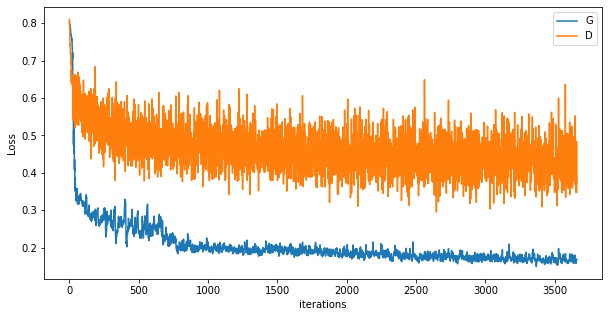

In [7]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(OUTPUT_PATH + "loss.png")
plt.show()

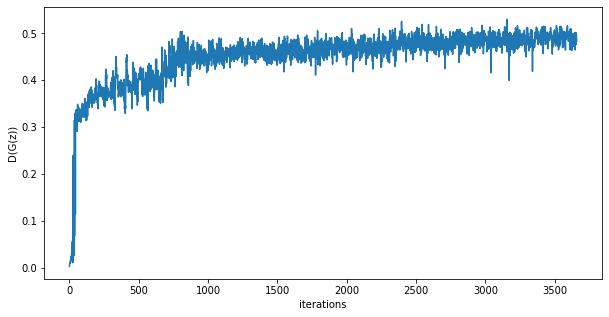

In [8]:
plt.figure(figsize=(10,5))
plt.plot(pred_G)
plt.xlabel("iterations")
plt.ylabel("D(G(z))")
plt.savefig(OUTPUT_PATH + "prob.png")
plt.show()

In [6]:
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(OUTPUT_PATH + 'G_params.pkl'))

<All keys matched successfully>

In [9]:
for i in range(10):
    fake_img_list = []
    for gen_num in range(1000):
        fixed_noise = torch.randn(BATCH_SIZE, nz, device=device)
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            fake = fake.tolist()
            fake_img_list.extend(fake)
    np.save(OUTPUT_PATH + "fake_" + str(i) + ".npy", np.array(fake_img_list))
    print("%d Done." % (i+1))

1 Done.
2 Done.
3 Done.
4 Done.
5 Done.
6 Done.
7 Done.
8 Done.
9 Done.
10 Done.
